# Baseline ST-MapMatching Algorithm Implementation
This notebook implements the baseline ST-MapMatching algorithm which already exists in the literature.

## Notebook Outline
1. Imports and Setup  
2. Load Data and Processing
3. Trajectory Sample Preparation
4. Define Algorithm Functions  
5. Run Map Matching  
6. Computation of Metrics
7. Visualization    

## 1. Imports and Setup

In [58]:
# Import necessary libraries for ST-MapMatching algorithm
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from osmnx import graph_from_place, save_graphml, load_graphml
from shapely.ops import nearest_points, unary_union, linemerge, substring, polygonize
from shapely.geometry import LineString, MultiLineString, Point
from scipy.spatial.distance import cosine
from copy import deepcopy
from math import sqrt, pi
import time
import pickle

## 2. Load Data and Processing

### Reading Trajectory Data

- Read trajectory data from CSV file.
- Convert trajectory DataFrame into a GeoDataFrame by creating shapely `Point` geometries
  from the longitude and latitude columns.
- Assign the coordinate reference system (CRS) as EPSG:4326 (WGS84).
- Convert velocity units from meters per second to kilometers per hour for later use.


In [59]:
# Reading the trajectory data
traj = pd.read_csv("car_traj_HF.csv")

# Turning the traj Dataframe into a GeoDataFrame using the Longitude and Latitude columns as Shapely points geometry and assigning the CRS
points = traj.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
traj = gpd.GeoDataFrame(traj, geometry=points)
traj.crs = "EPSG:4326"

In [60]:
traj.head(2)

,Timestamp,Device_type,Latitude,Longitude,Accuracy,Classification_type,Transformation_type,Delta_t,Delta_d,Velocity,Traj_ID,Time,Date,geometry,Delta_t_average,Velocity_average
0,1576258488,1,45.463135,9.199177,10.0,WHITELISTED,KEEP,281,135,0.480427,114,18:34:48,2019-12-13,POINT (9.19918 45.46313),20.416667,6.248252
1,1576258515,1,45.463806,9.199444,10.0,WHITELISTED,KEEP,27,77,2.851852,114,18:35:15,2019-12-13,POINT (9.19944 45.46381),20.416667,6.248252


In [61]:
# changing the unit of Velocity from [m/s] to [km/h] to use later in the algorithm functions:
traj['Velocity'] = traj['Velocity'] * 3.6

### Reading Network Data

- Load nodes and edges layers from a GeoPackage file representing Milan's drivable street network.
- Drop columns from nodes and edges that are not needed for the analysis to reduce memory and clutter.
- Preview the edges data.

In [62]:
# Reading the network data of the graph of drivable streets of Milan urban area from a Geopackage file with two layers of nodes and edges
nodes_drive = gpd.read_file("myMilan_drive.gpkg", layer="nodes")
edges_drive = gpd.read_file("myMilan_drive.gpkg", layer="edges")

# Removing some of the columns that are never used later
edges_drive.drop(columns=['junction', 'ref', 'bridge', 'tunnel', 'width', 'access', 'est_width'], inplace=True)
nodes_drive.drop(columns=['highway', 'ref', 'junction', 'railway', 'street_count', 'closeness', 'closeness_weighted', 'betweenness', 
                         'betweenness_weighted'], inplace=True)

In [63]:
edges_drive.head(2)

,u,v,key,osmid,highway,lanes,name,oneway,reversed,length,maxspeed,highway_str,speed_limit,geometry
0,10371529,743371634,0,274433644,primary,2,Via Novara,True,False,154.435012,30.0,primary,30.0,"LINESTRING (9.07662 45.48756, 9.07469 45.48785)"
1,10371529,743371622,0,26703159,tertiary,None,Via Novara,True,False,150.466270,30.0,tertiary,30.0,"LINESTRING (9.07662 45.48756, 9.07611 45.48771..."


### Loading the Graph Object

- Load the drivable street network graph from a GraphML file (retrieved previously from OpenStreetMap).
- This gives a `networkx.MultiDiGraph` object used for spatial analysis.
- Add a `geometry` attribute to each node by converting 'x' and 'y' coordinate attributes into shapely Point objects.


In [64]:
# This will give us a networkx MultiDiGraph that we use later for the analysis
milan_drive = load_graphml("milan_drive.graphml")

# Add a 'geometry' attribute to each node using its 'x' and 'y' coordinates
# This converts node positions into shapely Point objects for spatial analysis
for node, data in milan_drive.nodes(data=True):
    if 'x' in data and 'y' in data:
        data['geometry'] = Point(data['x'], data['y'])

## 3. Trajectory Sample Preparation

In this section, we sample a single trajectory to test the ST-MapMatching algorithm on a manageable subset first.
We also define a spatial buffer around sample points and adjust coordinate reference systems (CRS) for accurate spatial calculations.


In [65]:
# Sample a trajectory for testing: 
# Change sample_number to select a different trajectory sample from the dataset
sample_number = 0  
sample = traj[traj["Traj_ID"] == traj['Traj_ID'].unique()[sample_number]]

In [66]:
# Define the buffer distance around points (meters) and standard deviation used in observation probability
# Based on Lou et al. 2009, buffer is 100m with std dev 20, but we use 50m buffer to reduce computation time
point_buffer = 50 
standard_deviation = 20 

In [67]:
# Convert sample points to projected CRS (EPSG:6707) for accurate distance measurements
sample = sample.to_crs(epsg=6707)
# Create a buffer circle of size point_buffer (in meters) around each sample point
sample['small_buffer'] = sample.buffer(point_buffer)
# visualizing the sample poitns with the buffer around them
sample['small_buffer'].explore(tiles="CartoDB positron")

In [68]:
# Change network data CRS to projected coordinate system (EPSG:6707)
# to align with sample trajectory data for spatial analysis
edges_drive = edges_drive.to_crs(epsg=6707)
nodes_drive = nodes_drive.to_crs(epsg=6707)

### ---------------------------------------Now the Sample is ready--------------------------------------

## 4. Define Algorithm Functions

The following cells contains all the functions used in the ST-MapMatching algorithm.

### Score Matrix Structure

The score matrix is a 3D structure defined as:<br>
<em>score_matrix$[i][j][k] = score$<br>

- `i`: index of the current GPS point $P_i$
- `j`: index of the candidate for point `i-1`
- `k`: index of the candidate for point `i`
- `score` is the combined $observation$ and $transmission$ probability for this transition: $c_{i-1}^j \rightarrow c_{i}^k$ 


In [69]:
# ================================== Candidate points selection functions ===============================+

def get_candidate_points(gps_point, edges_gdf, buffer_radius=point_buffer):
    """
    Given a GPS point, return candidate road segments with projected points.

    Parameters:
    - gps_point: shapely Point (e.g., row['geometry'] from GPS data)
    - edges_gdf: GeoDataFrame of road segments (edges_drive)
    - buffer_radius: in meters

    Returns:
    - List of dicts with candidate data
    """
    # Create buffer around the GPS point
    buffer = gps_point.buffer(buffer_radius)

    # Filter edges that intersect with the buffer
    nearby_edges = edges_gdf[edges_gdf.intersects(buffer)]

    candidates = []

    for _, edge in nearby_edges.iterrows():
        # Project GPS point onto edge line
        projected_point = edge['geometry'].interpolate(
            edge['geometry'].project(gps_point)
        )
        dist = gps_point.distance(projected_point)
        # for each candidate the following features are saved in a dict:
        candidate = {
            'edge_osmid': edge['osmid'],
            'projected_point': projected_point,
            'distance': dist,
            'edge_geometry': edge['geometry'],
            'speed_limit': edge['speed_limit'],
            'u': edge['u'],
            'v': edge['v'],
            'key': edge['key']
        }

        candidates.append(candidate)

    return candidates

# -------------------------------------------------------------------------------------------+

def get_all_candidates(sample):
    """
    Loops through sample dataframe and runs get_candidate_points() on every gps point

    Parametes:
    -sample: dataframe of a sample trajectory 

    Returns:
    -List of lists of dicts
    """
    all_candidates = []  # This will be a list of lists — one list per GPS point

    for idx, row in sample.iterrows():
        gps_point = row.geometry
        candidates = get_candidate_points(gps_point, edges_drive, buffer_radius=point_buffer)
        all_candidates.append(candidates)
    return all_candidates    

# ====================================Observation Probability Function ===============================================+

def add_observation_probability(all_candidates, sigma=standard_deviation):
    """
    Computes the observation probability based on distance using a Gaussian model and adds it to the candidate dicts.
    It uses the constant standard deviation value defined previously (sigma = 20)

    Parameters:
    - all_candidates: the list of the candidate points
    - sigma: the standard deviation in the observation probability formula
    
    Returns:
    - doesn't return anything. Just modifies the input list of dictionaries
    """
    for candidate_list in all_candidates:
        for candidate in candidate_list:
            distance = candidate['distance']
            candidate['obs_prob'] = (1 / (sqrt(2 * pi) * sigma)) * np.exp(- (distance ** 2) / (2 * sigma ** 2))        

# =============================== Graph Manipulation Functions ============================================+

# -------------------------- Node Insertion Function -----------------------------------------+
def insert_virtual_node_directed(G, u, v, line_geom, projected_point, node_id):
    """
    Insert a virtual node along a directed edge (u, v) in graph G, splitting the edge into two segments.

    This function preserves all edge attributes and handles cases where the edge has
    been previously split. If other virtual nodes exist on the same edge, it connects
    them with shortcut edges to maintain graph connectivity.

    Parameters:
       - G (networkx.DiGraph): The graph containing the edge (u, v).
       - u (node): Source node of the edge.
       - v (node): Target node of the edge.
       - line_geom (shapely.geometry.LineString): Geometry of the original edge.
       - projected_point (shapely.geometry.Point): The point where the virtual node is inserted.
       - node_id (hashable): Identifier for the new virtual node.

    Returns:
        networkx.DiGraph: The updated graph with the virtual node and new edges inserted.
    """

    # Try to reconstruct geometry if edge (u, v) was already split
    if not G.has_edge(u, v):
        for nbr in G.successors(u):
            if isinstance(nbr, tuple) and G.has_edge(nbr, v):
                geom_u = G.nodes[u].get('geometry')
                geom_nbr = G.nodes[nbr].get('geometry')
                geom_v = G.nodes[v].get('geometry')

                if geom_u and geom_nbr and geom_v:
                    line_geom = LineString([geom_u, geom_nbr, geom_v])
                    break
        else:
            print(f"⚠️ Can't reconstruct geometry for edge ({u}, {v}) — missing node geometries.")
            return G

    # Interpolate projection point
    distance_on_line = line_geom.project(projected_point)
    point_on_line = line_geom.interpolate(distance_on_line)

    # Split original line at the projected point
    segment1 = LineString([line_geom.coords[0], (point_on_line.x, point_on_line.y)])
    segment2 = LineString([(point_on_line.x, point_on_line.y), line_geom.coords[-1]])

    # Safely extract attributes and avoid duplicate 'length'
    attrs = G.get_edge_data(u, v) or {}
    if 0 in attrs:  # If it's a MultiDiGraph with multiedges
        attrs = attrs[0]
    attrs = {k: v for k, v in attrs.items() if k != 'length'}

    # Remove original edge if it exists
    if G.has_edge(u, v):
        G.remove_edge(u, v)

    # Insert virtual node and new split edges
    G.add_node(node_id, geometry=projected_point)
    G.add_edge(u, node_id, length=segment1.length, **attrs)
    G.add_edge(node_id, v, length=segment2.length, **attrs)

    # Connect to any other virtual node already inserted on this edge
    for nbr in list(G.successors(u)):
        if isinstance(nbr, tuple) and nbr != node_id and G.has_edge(nbr, v):
            p1 = G.nodes[nbr]['geometry']
            p2 = projected_point
            dist = p1.distance(p2)

            G.add_edge(nbr, node_id, length=dist, is_virtual=True)
            G.add_edge(node_id, nbr, length=dist, is_virtual=True)

    return G

# ---------------------------- Euclidean Heuristic Function to use in A* algorithm ----------------------------+

def euclidean_heuristic(a, b, G):
    """
    Compute the straight-line (Euclidean) distance between two nodes in graph G.

    Parameters:
        a (node): The first node identifier.
        b (node): The second node identifier.
        G (networkx.Graph): The graph containing node geometries.

    Returns:
        float: Euclidean distance between the geometries of nodes a and b.
               Returns 0 if geometry is missing for either node.
    """
    geom_a = G.nodes[a].get('geometry')
    geom_b = G.nodes[b].get('geometry')
    if geom_a and geom_b:
        return geom_a.distance(geom_b)
    return 0

# --------------- Function to run A* algorithm to find the shortest path and its length 

def compute_network_distance_with_path(cand1, cand2, base_graph):
    """
    Compute the shortest network distance and corresponding edge path between two candidate points.

    This function inserts virtual nodes at the projected points of two candidates on the base graph,
    then runs A* shortest path search between these virtual nodes using a Euclidean heuristic.
    It returns both the shortest path length and the sequence of edges (with keys) along the path.

    Parameters:
        - cand1 (dict): Candidate point dictionary containing 'u', 'v', 'edge_geometry', and 'projected_point'.
        - cand2 (dict): Another candidate point dictionary with the same keys as cand1.
        - base_graph (networkx.DiGraph): The directed graph representing the road network.

    Returns:
        tuple:
            float: The shortest path distance between the two candidates (or infinity if no path exists).
            list of tuples: The edge path as a list of (u, v, key) tuples representing edges along the shortest path.
    """

    G = deepcopy(base_graph)
    id1 = ('virtual', 'A')
    id2 = ('virtual', 'B')

    try:
        G = insert_virtual_node_directed(G, cand1['u'], cand1['v'], cand1['edge_geometry'], cand1['projected_point'], id1)
        G = insert_virtual_node_directed(G, cand2['u'], cand2['v'], cand2['edge_geometry'], cand2['projected_point'], id2)
       
        # Running A* algorithm to find the shortest path between two nodes on the graph
        path = nx.astar_path(
            G, source=id1, target=id2,
            heuristic=lambda a, b: euclidean_heuristic(a, b, G),
            weight='length'
        )
        distance = nx.path_weight(G, path, weight='length')

        # Convert to edge path
        edge_path = []
        for u, v in zip(path[:-1], path[1:]):
            keys = list(G[u][v].keys()) if isinstance(G[u][v], dict) else [0]
            edge_path.append((u, v, min(keys)))

        return distance, edge_path

    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return float('inf'), []

# ===================== Score Matrix Construction Funcions =================================+

# ------------------------ Spatial Score Function ------------------------------------------+

def build_spatial_score_matrix(all_candidates, sample, base_graph, verbose=False):
    """
    Computes the spatial score matrix (obs × trans) and saves edge paths for temporal analysis.

    Parameters:
    - all_candidates: list of candidate lists for each GPS point
    - sample: GeoDataFrame of the GPS trajectory (must include 'Delta_d')
    - base_graph: NetworkX DiGraph of road network
    - verbose: if True, prints debug info

    Returns:
    - score_matrix: nested dict [i][j][k] = obs × trans
    - edge_path_matrix: nested dict [i][j][k] = list of (u, v, key) edges
    """
    score_matrix = {}
    edge_path_matrix = {}

    for i in range(1, len(sample)):
        score_matrix[i] = {}
        edge_path_matrix[i] = {}

        gps_dist = sample.iloc[i].Delta_d

        for j, cand_prev in enumerate(all_candidates[i - 1]):
            score_matrix[i][j] = {}
            edge_path_matrix[i][j] = {}

            for k, cand_curr in enumerate(all_candidates[i]):
                obs_prob = cand_curr.get('obs_prob', 0)

                # Compute network distance and edge path
                net_dist, edge_path = compute_network_distance_with_path(cand_prev, cand_curr, base_graph)

                trans_prob = gps_dist / net_dist if net_dist not in [0, float('inf')] else 0.0
                score = obs_prob * trans_prob

                # Optional logging
                if verbose:
                    print(f'Trying: P{i-1} cand {j} → P{i} cand {k}   | '
                          f'net_dist = {net_dist:.2f}   | gps_dist = {gps_dist:.2f}   | '
                          f'obs = {obs_prob:.6f}   | trans = {trans_prob:.6f}   | score = {score:.6f}')

                # Save both score and edge path
                score_matrix[i][j][k] = score
                edge_path_matrix[i][j][k] = edge_path

    return score_matrix, edge_path_matrix

# ------------------------- Temporal Score Function ------------------------------------------------+ 

def build_temporal_matrix(sample, edge_path_matrix, all_candidates, edges_drive, verbose=False):
    """
    Build the temporal similarity matrix based on the cosine similarity between 
    actual GPS speeds and expected speeds from matched road segments.

    The matrix compares each candidate transition’s expected speed profile 
    to the observed speed, accounting for virtual edges and real road segments.

    Parameters:
        - sample (GeoDataFrame): GPS trajectory data with a 'Velocity' column.
        - edge_path_matrix (dict): Nested dictionary containing edge paths between candidate points.
        - all_candidates (list): List of candidate points for each GPS point.
        - edges_drive (GeoDataFrame): Road network edges containing speed limit information.
        - verbose (bool): If True, prints detailed debug information.

    Returns:
        dict: Nested dictionary temporal_matrix[i][j][k] with cosine similarity scores 
              representing temporal similarity between candidates j and k at points i-1 and i.
    """
    temporal_matrix = {}

    for i in range(1, len(sample)):
        v_actual = sample.iloc[i].Velocity
        temporal_matrix[i] = {}

        for j in range(len(all_candidates[i - 1])):
            temporal_matrix[i][j] = {}

            for k in range(len(all_candidates[i])):
                edge_path = edge_path_matrix[i][j][k]
                expected_speeds = []

                # Include entry (from previous candidate)
                entry_speed = all_candidates[i - 1][j].get('speed_limit', None)
                if entry_speed is not None:
                    expected_speeds.append(entry_speed)

                # Internal edges (skip virtual ones)
                for u, v, key in edge_path:
                    if isinstance(u, tuple) or isinstance(v, tuple):
                        continue
                    match = edges_drive[
                        (edges_drive['u'] == u) & (edges_drive['v'] == v) & (edges_drive['key'] == key)
                    ]
                    if not match.empty:
                        speed = match.iloc[0]['speed_limit']
                        expected_speeds.append(speed)
                    elif verbose:
                        print(f"⚠️  No match found for edge: u={u}, v={v}, key={key}")

                # Include exit (to next candidate)
                exit_speed = all_candidates[i][k].get('speed_limit', None)
                if exit_speed is not None:
                    expected_speeds.append(exit_speed)

                # Compute similarity
                if len(expected_speeds) == 1:   # if there is only one edge between the two points 
                    sim = 1.0
                elif len(expected_speeds) == 0:
                    sim = 0.0
                else:
                    actual_vector = [v_actual] * len(expected_speeds)
                    try:
                        sim = 1 - cosine(actual_vector, expected_speeds)
                        sim = sim if not np.isnan(sim) else 0.0
                    except:
                        sim = 0.0

                temporal_matrix[i][j][k] = sim

                if verbose:
                    print(f"\n--- Temporal Score: P{i-1} cand {j} → P{i} cand {k} ---")
                    print(f"• Number of edges   : {len(edge_path)}")
                    print(f"• Expected speeds   : {[round(float(s), 1) for s in expected_speeds]}")
                    print(f"• Actual GPS speed  : {v_actual:.2f}")
                    print(f"• Cosine similarity : {sim:.4f}")

    return temporal_matrix

# ============================= Candidate Graph Construction and Analysis Functions (DAG) ===========================+

# -------------------------- Candidate Graph Creation Function ----------------------------+

def build_candidate_graph(all_candidates, score_matrix, temporal_matrix):
    """
    Builds the candidate graph as described in the ST-Matching paper.

    Parameters:
    - all_candidates (list of list of dict): Candidate points for each GPS observation.
    - score_matrix (dict): Nested spatial score matrix indexed as [i][j][k].
    - temporal_matrix (dict): Nested temporal similarity matrix indexed as [i][j][k].
    
    Returns:
    - G: a NetworkX DiGraph representing the candidate graph
    """
    G = nx.DiGraph()

    # Add all candidate nodes with observation probabilities
    for i, candidates in enumerate(all_candidates):
        for k, cand in enumerate(candidates):
            G.add_node((i, k), geometry=cand['projected_point'], obs_prob=cand['obs_prob'])

    # Add edges between candidates of consecutive points
    for i in range(1, len(all_candidates)):
        for j in range(len(all_candidates[i - 1])):
            for k in range(len(all_candidates[i])):
                spatial_score = score_matrix[i][j][k]
                temporal_score = temporal_matrix[i][j][k]
                final_score = spatial_score * temporal_score

                if final_score > 0:
                    G.add_edge((i - 1, j), (i, k),
                               score=final_score,
                               trans_prob=spatial_score,
                               temp_sim=temporal_score,
                               weight=final_score)  # keep weight for networkx algorithms


    return G

# -------------------- Function to find the best path in the candidate graph based on the scores ----------------+

def find_best_path(G):
    """
    Finds the highest scoring path in the DAG candidate graph using topological sort + dynamic programming.
    
    The graph nodes represent candidate points, and edges represent transitions weighted by scores.
    This function computes the path with the maximum cumulative score.
    
    Parameters:
    - G: candidate graph (NetworkX DiGraph)

    Returns:
    - best_path: list of node IDs (tuples like (i, k)) forming the best candidate path
    """
    # Initialize score and predecessor dictionaries
    score = {}
    predecessor = {}

    # Topological order traversal
    topo_order = list(nx.topological_sort(G))

    for node in topo_order:
        # Get incoming edges
        preds = G.in_edges(node, data=True)

        if not preds:
            # Start nodes: base score = obs_prob only
            score[node] = G.nodes[node].get('obs_prob', 0.0)
            predecessor[node] = None
        else:
            # Maximize over all incoming transitions
            max_score = -float('inf')
            best_pred = None
            for u, v, data in preds:
                edge_score = score.get(u, 0.0) + data['weight']
                if edge_score > max_score:
                    max_score = edge_score
                    best_pred = u
            score[node] = max_score
            predecessor[node] = best_pred

    # Backtrack from node with highest final score
    end_node = max(score, key=score.get)
    best_path = []
    current = end_node

    while current is not None:
        best_path.append(current)
        current = predecessor[current]

    best_path.reverse()
    return best_path

# ---------------------------- Visualization Function of the candidate graph ------------------------------------+

def plot_abstract_candidate_graph(G, best_path=None, start_layer=0, end_layer=5):
    """
    Abstract visualization of the candidate graph (not map-based), showing a specific range of GPS point layers.
    
    Parameters:
    - G: candidate graph (NetworkX DiGraph)
    - best_path: list of (i, k) tuples representing the best candidate path (optional)
    - start_layer: starting GPS point index (inclusive)
    - end_layer: ending GPS point index (exclusive)
    """
    pos = {}  # positions for drawing
    nodes_to_include = []

    # Layout: x = point index (layer), y = candidate index
    for (i, k) in G.nodes:
        if start_layer <= i < end_layer:
            pos[(i, k)] = (i, -k)  # negative k so it draws top-down
            nodes_to_include.append((i, k))

    # Subgraph for just selected layers
    subgraph = G.subgraph(nodes_to_include)

    plt.figure(figsize=(12, 8))

    # First: draw all edges in light gray
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True)

    # Then: if best path is provided, draw it on top
    if best_path is not None:
        best_edges = list(zip(best_path[:-1], best_path[1:]))  # edges between consecutive nodes
        nx.draw_networkx_edges(subgraph, pos,
                               edgelist=best_edges,
                               edge_color='#DC143C',  # Best path in RED
                               width=2,
                               arrows=True)

    # Draw nodes and labels
    nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=300)
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    plt.title(f"Abstract View of Candidate Graph (P{start_layer} to P{end_layer - 1})")
    plt.axis('off')
    plt.show()
    
# ===================== Getting the Final Matched Points and Edges =========================+   

def get_matched_points_and_edges(candidate_points, best_candidate_path, edge_path, edges_gdf, sample):
    """
    The function returns two geodataframes of matched point and matched edges from the best candidate path

    Parameters:
    - candidate_points: list of dicts of all candidate points
    - best_candidate_path: a list of tuples which is the output of finding the best path function
    - edge_path: the edge path matrix
    - edges_gdf: the geodataframe of the edges of the network
    - sample: the geodataframe of the gps sample points

    Returns:
    two GeoDataFrames of the matched points and the path edges
    """
    matched_points = [
    candidate_points[i][k]['projected_point']
    for (i, k) in best_candidate_path
    ]
    matched_points_gdf = gpd.GeoDataFrame(geometry=matched_points, crs=sample.crs)
    
    #edges that contain a matched point:
    ##if two consecutive points are matched on the same edge (considering the direction), this will include that edge only once:
    matched_edges = []
    previous_edge = None

    for (i, k) in best_candidate_path:
        cand = candidate_points[i][k]
        
        current_edge = (cand['u'], cand['v'], cand['key'])
    
        if previous_edge != current_edge:
            selected_edge = edges_gdf[(edges_gdf['u'] == cand['u']) & (edges_gdf['v'] == cand['v']) & (edges_gdf['key'] == cand['key'])]
            matched_edges.append(selected_edge)  
            previous_edge = current_edge

    matched_edges_gdf = pd.concat(matched_edges, ignore_index=True)
    
    #edges that don't contain a matched point:
    matched_edges_vir = []
    for (i1, k1), (i2, k2) in zip(best_candidate_path[:-1], best_candidate_path[1:]):
        edge_list = edge_path[i2][k1][k2]
    
        # Keep all real edges (in the middle)
        for (u, v, key) in edge_list:
            if not isinstance(u, tuple) and not isinstance(v, tuple):
                matched_edges_vir.append((u, v, key))
    
    # 2. Get geometries from edges_drive
    # Step 1: Turn matched_edges_vir into a DataFrame directly
    matched_edges_vir_df = pd.DataFrame(matched_edges_vir, columns=['u', 'v', 'key'])
    
    # Step 2: Merge with edges_drive to get full attributes (osmid, geometry, etc.)
    matched_edges_vir_df = matched_edges_vir_df.merge(
        edges_gdf,
        on=['u', 'v', 'key'],
        how='left'
    )
    matched_edges_vir_gdf = gpd.GeoDataFrame(matched_edges_vir_df, geometry='geometry', crs=edges_drive.crs)
    
   # matched_edge_vir_gdf = edges_gdf[
   #     edges_gdf.apply(lambda row: (row['u'], row['v'], row['key']) in matched_edges_vir, axis=1)    older version
   # ].copy()

    #concatenating the edges:
    path_edges_gdf = pd.concat([matched_edges_gdf, matched_edges_vir_gdf])
    return matched_points_gdf, path_edges_gdf

###======================================== Functions used in Metric calculations ==========================================+

# ------------------------- Function to remove extra parts of the begining and ending of the matched path -------------------+
def trim_path_by_geometry(matched_path, best_candidate_path, all_candidate_points):
    """
    Trim the first and last matched edges based on projected points,
    and replace them only in the corresponding rows in the matched_path.
    
    Parameters:
       - matched_path (GeoDataFrame): GeoDataFrame containing the matched edges of the path.
       - best_candidate_path (list of tuple): List of (i, k) tuples representing the best candidate indices per GPS point.
       - all_candidate_points (list of list of dict): All candidate points with their projected points and edge geometries.
       
    Returns:
        GeoDataFrame: A new GeoDataFrame with the first and last edges trimmed according to the projected points.    
    """

    # Extract first and last candidate point info
    first_i, first_k = best_candidate_path[0]
    last_i, last_k = best_candidate_path[-1]

    first_proj = all_candidate_points[first_i][first_k]['projected_point']
    last_proj  = all_candidate_points[last_i][last_k]['projected_point']

    first_geom = all_candidate_points[first_i][first_k]['edge_geometry']
    last_geom  = all_candidate_points[last_i][last_k]['edge_geometry']

    # Trim them
    trimmed_first = substring(first_geom, first_geom.project(first_proj), first_geom.length)
    trimmed_last  = substring(last_geom, 0, last_geom.project(last_proj))

    # Copy the geometry list
    trimmed_geoms = matched_path.geometry.tolist()

    # Replace first match
    for idx, g in enumerate(trimmed_geoms):
        if g.equals(first_geom):
            trimmed_geoms[idx] = trimmed_first
            break

    # Replace last match
    for idx in reversed(range(len(trimmed_geoms))):
        if trimmed_geoms[idx].equals(last_geom):
        #if trimmed_geoms[idx].almost_equals(last_geom, decimal=6):    
            trimmed_geoms[idx] = trimmed_last
            break

    return gpd.GeoDataFrame(geometry=trimmed_geoms, crs=matched_path.crs)
    
# ---------------------------- Trim when the whole path is a single edge ----------------------------+

def trim_single_edge(matched_path, best_candidate_path, all_candidate_points):
    """
    Trim a single edge path based on start and end projected points.

    This function is useful when the entire matched path lies on one LineString edge.
    It trims the edge geometry between the projected start and end points.

    Parameters:
       - matched_path (GeoDataFrame): GeoDataFrame containing the matched path geometry.
       - best_candidate_path (list of tuple): List of (i, k) tuples indicating the best candidate indices.
       - all_candidate_points (list of list of dict): All candidate points including projected points and edge geometries.

    Returns:
        GeoDataFrame: A GeoDataFrame containing the trimmed geometry segment.    
    """

    # Get start and end projections
    first_i, first_k = best_candidate_path[0]
    last_i, last_k = best_candidate_path[-1]

    first_proj = all_candidate_points[first_i][first_k]['projected_point']
    last_proj  = all_candidate_points[last_i][last_k]['projected_point']

    edge_geom = all_candidate_points[first_i][first_k]['edge_geometry']

    start_d = edge_geom.project(first_proj)
    end_d   = edge_geom.project(last_proj)

    # Ensure proper direction
    start_d, end_d = min(start_d, end_d), max(start_d, end_d)

    trimmed_geom = substring(edge_geom, start_d, end_d)

    # Return as GeoDataFrame
    return gpd.GeoDataFrame(geometry=[trimmed_geom], crs=matched_path.crs)
###==================================================================================================> smart_trim_path
def smart_trim_path(matched_path, best_candidate_path, all_candidate_points):
    """
    Trim the matched path intelligently based on its structure.

    If the matched path consists of a single edge, it calls `trim_single_edge`.
    Otherwise, it calls `trim_path_by_geometry` for the general multi-edge case.

    Parameters:
       - matched_path (GeoDataFrame): GeoDataFrame of matched edges.
       - best_candidate_path (list of tuple): List of best candidate indices (i, k).
       - all_candidate_points (list of list of dict): Candidate points with projected points and edge geometries.

    Returns:
        GeoDataFrame: Trimmed matched path as a GeoDataFrame.
    """
    
    if len(matched_path) == 1:
        # All points lie on the same edge
        return trim_single_edge(matched_path, best_candidate_path, all_candidate_points)
    else:
        # General case
        return trim_path_by_geometry(matched_path, best_candidate_path, all_candidate_points)

###=====================================================================================> safe_linemerge() 
def safe_linemerge(geoms):
    """
    Safely merge multiple LineString geometries into a single geometry.

    Performs a unary union and attempts to merge resulting geometries.
    Raises an error if the resulting geometry type is unexpected.

    Parameter:
        geoms (list): List of shapely LineString geometries.

    Returns:
        LineString or MultiLineString: Merged geometry.
    
    Raises:
        ValueError: If the merged geometry type is not LineString or MultiLineString.
    """    
    unioned = unary_union(geoms)
    if isinstance(unioned, MultiLineString):
        return linemerge(unioned)
    elif isinstance(unioned, LineString):
        return unioned
    else:
        raise ValueError("Unexpected geometry type for merging.")

### Final ST_Matching function that calls all the other functions to run the algorithm:

In [70]:
def ST_Matching(sample, network, edges_gdf, verbose=False):
    """
    Perform the full Spatial-Temporal (ST) Map Matching algorithm on a GPS trajectory sample.

    The function executes the following steps:
    1. Finds candidate road segments for each GPS point.
    2. Computes observation probabilities for candidates.
    3. Builds spatial and temporal score matrices.
    4. Constructs the candidate graph.
    5. Finds the best candidate path through the graph.
    6. Extracts matched points and the final matched path.

    Parameters:
        sample (GeoDataFrame): GPS trajectory points with geometry and velocity.
        network (networkx.DiGraph): Directed graph of the road network.
        edges_gdf (GeoDataFrame): GeoDataFrame of road edges including speed limits.
        verbose (bool): If True, print detailed processing information.

    Returns:
        dict: Contains the following keys:
            - 'candidate_points': List of all candidate points per GPS observation.
            - 'score_matrix': Nested spatial score matrix.
            - 'edge_path': Nested dictionary of edge paths between candidates.
            - 'temporal_matrix': Nested temporal similarity matrix.
            - 'graph': NetworkX DiGraph representing candidate graph.
            - 'best_path': List of nodes representing the best candidate path.
            - 'matched_points': GeoDataFrame of matched candidate points.
            - 'matched_path': GeoDataFrame of the final matched road path.
    """    
    #finding the candidates
    all_candidate_points = get_all_candidates(sample)
    #adding the observation probability to the candidates
    add_observation_probability(all_candidate_points)
    #spatial score
    score_matrix, edge_path = build_spatial_score_matrix(all_candidate_points, sample, network, verbose=verbose)
    #temporal score
    temporal_matrix = build_temporal_matrix(sample, edge_path, all_candidate_points, edges_gdf, verbose=verbose)
    #build candidate graph
    candidate_graph = build_candidate_graph(all_candidate_points, score_matrix, temporal_matrix)
    #finding the best (longest) path
    best_candidate_path = find_best_path(candidate_graph)
    #getting the matched points and the final path 
    matched_points, matched_path = get_matched_points_and_edges(all_candidate_points, best_candidate_path, edge_path, edges_gdf, sample)
    return {
    'candidate_points': all_candidate_points,
    'score_matrix': score_matrix,
    'edge_path': edge_path,
    'temporal_matrix': temporal_matrix,
    'graph': candidate_graph,
    'best_path': best_candidate_path,
    'matched_points': matched_points,
    'matched_path': matched_path
    }

## 5. Run Map Matching

This section runs the full ST-Matching algorithm on the prepared sample and network data.

- It times the execution to monitor performance.
- The results dictionary is unpacked into separate variables for easier access.
- The key outputs include candidate points, score matrices, candidate graph, best path, and the final matched points and path.


In [71]:
%%time
start = time.perf_counter()
results = ST_Matching(sample, milan_drive, edges_drive)
end = time.perf_counter()
candidate_points = results['candidate_points']
spatial_matrix = results['score_matrix']
temporal_matrix = results['temporal_matrix']
edge_path = results['edge_path']
candidate_graph = results['graph']
best_candidate_path = results['best_path']
matched_points = results['matched_points']
matched_path = results['matched_path']

CPU times: total: 10min 8s
Wall time: 10min 8s


## 6. Computation of Metrics

In this section, we compute key metrics to evaluate the performance and quality of the ST-Matching algorithm, including:

- Trajectory sample identification  
- Algorithm runtime  
- Average number of candidate points per GPS sample  
- Average spatial error between GPS points and matched points  
- Edge and street revisit counts indicating loops in the matched path  
- Length-based metrics comparing matched path length with GPS sample length  
- Number of loops detected in the matched path  
- Speed consistency metrics  
- Path complexity ratio comparing path length to direct start-to-end distance  

Finally, all computed metrics, key results, and intermediate data structures are consolidated into a summary dictionary for easy access, analysis, and reporting.
This makes it possible later in a batch running operation to run the algorithm on a series of samples and keep the summaries for further analysis


In [76]:
# 1. id of the trajectory sample
traj_id = int(sample['Traj_ID'].iloc[0])

# 2. Algorithm runtime
runtime = end - start #runtime of the algorithm in seconds

# 3. average number of candidate points per sample point
number_of_candidate_points = 0
for p in candidate_points:
    number_of_candidate_points += len(p)  

avg_cand_per_sample = number_of_candidate_points / len(sample)

# 4. average distance between the sample points and their matched point
matched_points_dist = [
    candidate_points[i][k]['distance']
    for (i, k) in best_candidate_path
    ]

average_distance = sum(matched_points_dist) / len(matched_points_dist)

# 5. number of times edges are revisited in the path
# (1) Revisited edges (exact u, v, key match)
edge_revisit = len(matched_path) - matched_path[['u', 'v', 'key']].drop_duplicates().shape[0]
# (2) Revisited streets (osmid match)
street_revisit = len(matched_path) - matched_path['osmid'].nunique()

# 6. Length metric
     
trimmed_path = smart_trim_path(matched_path, best_candidate_path, candidate_points)
merged_trimmed = safe_linemerge(unary_union(trimmed_path.geometry))
matched_path_length = merged_trimmed.length
sample_aprx_length = sample['Delta_d'][1:].sum()
length_metric = sample_aprx_length / matched_path_length

# 7. number of loops in the path
polygons = list(polygonize(merged_trimmed))
number_of_loops = len(polygons)

# 8. speed metric
path_speed = matched_path_length / sample.Delta_t.iloc[1:].sum()
sample_speed = sample.Delta_d.iloc[1:].sum() / sample.Delta_t.iloc[1:].sum()

# 9. path complexity ratio ---> length of path / direct distance of first and last point
direct_distance = sample['geometry'].iloc[0].distance(sample['geometry'].iloc[-1])
complexity_ratio = matched_path_length / direct_distance

In [79]:
    summary = {
    'traj_id': traj_id,
    'mean_proj_distance': average_distance,         # average distance between GPS and matched point
    'path_length': matched_path_length,             # total matched path length
    'sample_length': sample_aprx_length,            # sum of delta_d from sample
    'length_metric': length_metric,                 # sample length / path length
    'num_candidates': number_of_candidate_points,   # total number of candidate points
    'avg_num_candidates': avg_cand_per_sample,      # avg number of candidates per GPS point
    'path_speed': path_speed,                       # average path speed (m/s)
    'sample_speed': sample_speed,                   # Sample speed calculated by delta_d and delta_t (m/s)
    'runtime_seconds': runtime,                     # time taken
    'revisited_edges': edge_revisit,                # number of times an edge is revisited in the path
    'revisited_streets': street_revisit,            # number of times an street is revisited in different directions    
    'num_loops': number_of_loops,                   # number of loops in the final matched path
    'complexity_ratio': complexity_ratio,           # length of the path / direct distance between the first and last point
    'buffer_type': 'fixed',                         # a fixed number based (50 meters) 
    'sigma_type': 'fixed',                          # a fixed experimental value (20)
    'matched_points': matched_points,               # list of shapely Points (projected or final)
    'matched_path': matched_path,                   # Dataframe of LineStrings
    'trimmed_path': trimmed_path,                   # Dataframe of LineStrings with the beginning and ending of the path trimmed    
    'candidate_points': candidate_points,           # List of candidate all points
    'spatial_matrix': spatial_matrix,               # Spatial score matrix --> obs * trans
    'temporal_matrix': temporal_matrix,             # Temporal score matrix
    'edge_path': edge_path,                         # edges of the shortest paths
    'candidate_graph': candidate_graph,             # the candidate DAG graph
    'best_candidate_path': best_candidate_path      # a list of tuples of the selected candidate points from the graph
        }

## 7. Visualization

This section provides visual insights into the ST-Matching results:

- **Candidate Graph:** An abstract Directed Acyclic Graph (DAG) view showing candidate points and the selected best path.
- **Sample Points:** Original GPS trajectory points visualized in red.
- **Matched Points:** Matched candidate points overlaid in green.
- **Final Path:** The refined matched path displayed in blue.

Interactive maps use CartoDB Positron tiles for a clean base map.


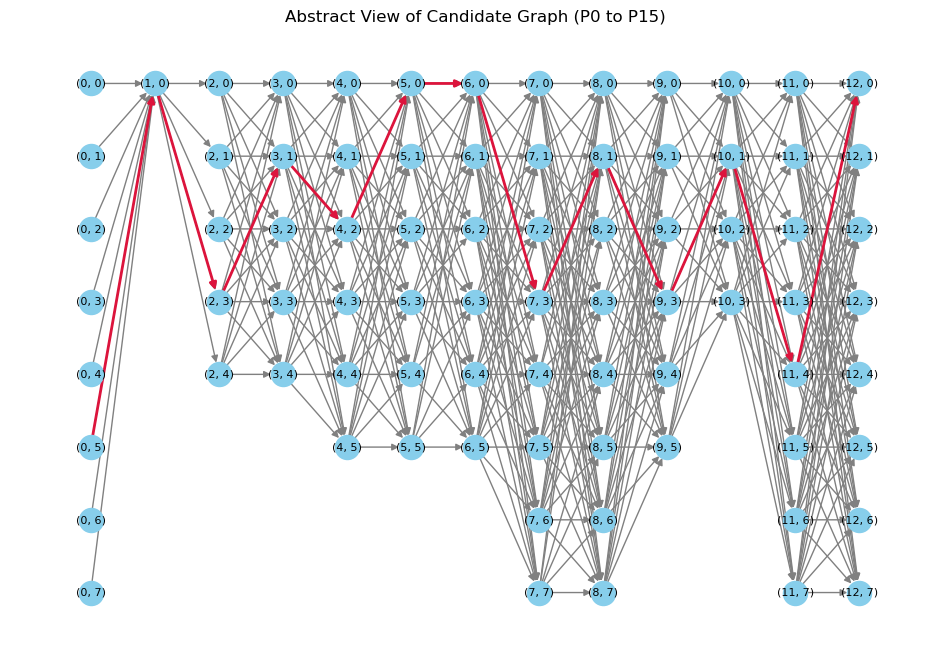

In [72]:
#Visualizing the candidate graph (DAG) and highlighting the selected best path and candidate points
plot_abstract_candidate_graph(candidate_graph, start_layer=0, end_layer=16, best_path=best_candidate_path)

In [78]:
# Visualizing the results on the map
s = sample.explore(tiles="CartoDB positron", color='red')
mp = matched_points.explore(m=s, tiles='CartoDB positron', color='green')
trimmed_path.explore(m=mp, tiles="CartoDB positron", color='blue')